# Running Finesse simulations in parallel
A summary of the various methods to do this.

There are 3 methods:

* built-in method: `parakat`
* using the same packages as parakat: `ipyparallel`
* alternate method using python standard method: `multiprocessing`

Let's use the same basic function in all cases. For parakat we need the kat code separate, for the other two we'll need it inside a function:

In [1]:
from pykat import finesse
import matplotlib.pyplot as plt
import time
%matplotlib inline

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In this example we parse the Finesse code for a gaussian beam propagating to a mirror, and measure the power transmitted through the mirror as the laser's power is varied linearly from 1W to 100W. Each parallel job then repeats this process for a different value of mirror transmission.

In [2]:
n_eng = 8 # max number of parallel tasks
xsteps = 10000  # xaxis resolution in each job
n_jobs = 100    # total number of different jobs we need to iterate through

katcode = f"""
l L0 1 0 n0
gauss mybeam L0 n0 100u 0 101u 1m
maxtem 4
s s0 0 n0 n1
m m 0.5 0.5 0 n1 nout
pd P nout
xaxis L0 P lin 1 100 {xsteps}"""

vals = range(1,n_jobs)
testvals = [v/n_jobs for v in vals]

## parakat
The parakat method only does the explicit _Finesse_ calculation in parallel, so it's functionality is a bit more limited. But it does have a nice progress bar :)

Parakat uses `ipyparallel`. Therefore, like the more explicit usage we'll see below, we first have to externally tell `ipcluster` to start the number of engines we need. 

We can do this in a terminal, less directly using the `!` flag, or slightly more pythonically:

In [3]:
import subprocess
subprocess.run(f"ipcluster start -n {n_eng} --daemonize",shell=True) #daemon and Popen both make this happen in the background
time.sleep(10) #wait a sec for the cluster to start up

now we set up the code as normal using pykat:

In [4]:
base=finesse.kat()
base.verbose=False
base.parse(katcode)

and now we work slightly differently to a serial pykat run:

In [5]:
from pykat.parallel import parakat

pk = parakat()
for T in testvals:
    kat = base.deepcopy()
    kat.m.setRTL(1-T,T,0)
    pk.run(kat)
outs = pk.getResults() 

/Users/annagreen/miniconda3/envs/myenv/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for Techs-MacBook-Pro.local: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

now that we're done with them, let's stop those engines:

In [6]:
subprocess.run(f"ipcluster stop",shell=True)
time.sleep(10) #wait a sec for the cluster to shut down

plotting the results:

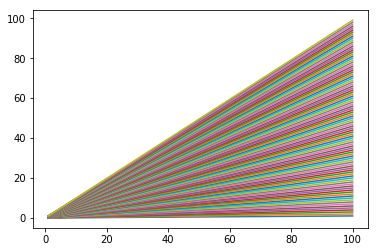

In [7]:
for o in outs:
    plt.plot(o.x,o['P'])

## ipyparallel

this is quite similar to parakat, but more flexible since we are directly parsing the python/pykat code of choice. It could therefore be extended to include further post-processing, multiple kat runs, etc.

Once again we start the engines externally:

In [8]:
import subprocess
import time
subprocess.run(f"ipcluster start -n {n_eng} --daemonize",shell=True) #daemon and Popen both make this happen in the background
time.sleep(10) #wait a sec for the cluster to start up

this time, we need to create a _function_ which describes what we want to happen in each job. Unfortunately, this can't reply on any external dependancies, so we have to import pykat inside it, and either explicitly write out the katcode or add it as another variable (shown here)

In [9]:
def myfunc(T,code):
    from pykat import finesse
    k=finesse.kat()
    k.verbose=False
    k.parse(code)
    k.m.setRTL(1-T,T,0)
    o=k.run()
    return o

and now we run the code in parallel. 

<font size=2>
    NB `rc.load_balanced_view()` creates a DirectView object with load-balanced execution using all engines; if you don't want that for e.g. memory usage reasons, use `rc.direct_view()` instead to skip the load balancing.
</font>

In [10]:
from ipyparallel import Client

rc=Client() #class object to start the client to the parallel cluster
lview = rc.load_balanced_view()#creates a DirectView object with load-balanced execution using all engines
lview.block = False # if self.block is False, returns AsyncResult, else: returns actual result of f(*args, **kwargs) on the engine(s)
results = [lview.apply_async(myfunc,yy,katcode) for yy in testvals] #easy enough to add the second 'code' arg to apply_async here
outs = [d.get() for d in results]
rc.close()#good practice, if unessential on some local machines


once again we now stop those engines manually:

In [11]:
subprocess.run(f"ipcluster stop",shell=True)
time.sleep(10) #wait a sec for the cluster to shut down

and plotting the results:

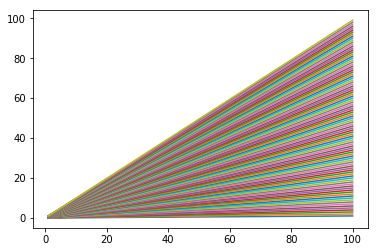

In [12]:
for o in outs:
    plt.plot(o.x,o['P'])

## multiprocessing

This is simpler and cleaner than the above, since engine start/stop is handled internally. However, it might be a little less flexible in what can be iterated over, and engines are restricted to running on the local machine, while ipyparallel enables you to send jobs to remote machines and more.

Like `ipyparallel`, we need to iterate over a _function_; unlike ipyparallel this *doesn't* seem to require pykat be defined every time:

In [13]:
def myfunc2(T,code):
    k=finesse.kat()
    k.verbose=False
    k.parse(code)
    k.m.setRTL(1-T,T,0)
    o=k.run()
    return o

then everything is handled internally, we just need:

<font size=2>
NB: you can also use 

<tt>outs = [pool.apply(myfunc2, args=(x,katcode)) for x in testvals]</tt>   
in place of    
<tt>
results = [pool.apply_async(myfunc2, args=(x,katcode)) for x in testvals]    
outs = [p.get() for p in results]
</tt>  
--this locks the code to run things in order (still in parallel) rather than launching all jobs, you guessed it, asynchronously whenever space frees up. So it's one less line of code but slightly slower, in cases where synchronicity is important
</font>

In [14]:
from multiprocessing import Pool

pool = Pool(processes=n_eng)
results = [pool.apply_async(myfunc2, args=(x,katcode)) for x in testvals]
outs = [p.get() for p in results]
pool.close()#good practice, necessary on some machines


and plotting the results:

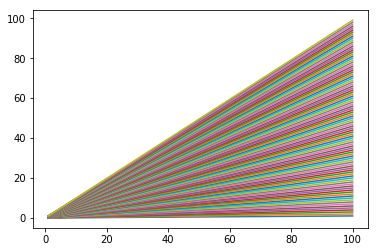

In [15]:
for o in outs:
    plt.plot(o.x,o['P'])

## Speed comparison

In [16]:
#exclude the start up time for ipyparallel tasks for this test
subprocess.run(f"ipcluster start -n {n_eng} --daemonize",shell=True) #daemon and Popen both make this happen in the background
time.sleep(10) #wait a sec for the cluster to start up

#parakat
t_start = time.time()
pk = parakat()
for T in testvals:
    kat = base.deepcopy()
    kat.m.setRTL(1-T,T,0)
    pk.run(kat)
outs = pk.getResults() 
print(f"parakat duration:         {time.time()-t_start:.3f}s")

#ipyparallel
t_start = time.time()
rc=Client() #class object to start the client to the parallel cluster
lview = rc.load_balanced_view()#creates a DirectView object with load-balanced execution using all engines
lview.block = False # if self.block is False, returns AsyncResult, else: returns actual result of f(*args, **kwargs) on the engine(s)
results = [lview.apply_async(myfunc,yy,katcode) for yy in testvals] #easy enough to add the second 'code' arg to apply_async here
outs = [d.get() for d in results]
print(f"ipyparallel duration:     {time.time()-t_start:.3f}s")
rc.close()

#shut down the ipcluster
subprocess.run(f"ipcluster stop",shell=True)
time.sleep(10) #wait a sec for the cluster to shut down

#multiprocessing
t_start=time.time()
pool = Pool(processes=n_eng)
results = [pool.apply_async(myfunc2, args=(x,katcode)) for x in testvals]
outs = [p.get() for p in results]
print(f"multiprocessing duration: {time.time()-t_start:.3f}s")
pool.close()

Parallel jobs: 100%|##########################################################|

parakat duration:         7.982s
ipyparallel duration:     5.660s
multiprocessing duration: 5.287s


If you run the above multiple times, you'll see that pykat tends to be the slowest, while ipyparallel and multiprocessing are nearly matched (winner seems to depend on your system). I suspect this is the time taken to launch progress bars etc. 

I suspect if you need to run many parallel runs one after another, ipyparallel-based work will be faster as you can keep the cluster running between jobs. Multiprocessing must be spawning and closing the cluster for every run, which could be less efficient longer term.